In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import os
import time

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

Text(0.5, 1.0, '20 Samples from P & Q')

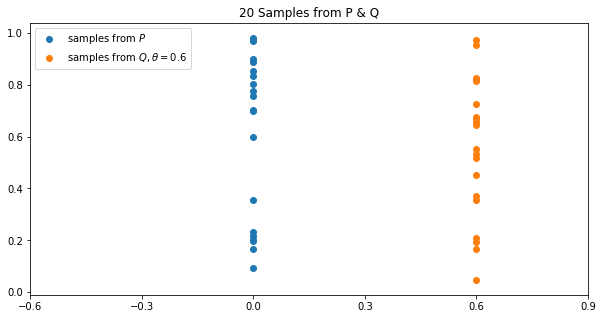

In [9]:
n = 20
plt.figure(figsize=[10,5])
plt.scatter(np.zeros(n), np.random.random(n), label='samples from $P$')
plt.scatter(np.ones(n)*0.6, np.random.random(n), label=r'samples from $Q, \theta = 0.6$')
plt.xticks([-0.6, -0.3, 0.0, .3,.6, .9])
plt.legend(loc='upper left')
plt.title("20 Samples from P & Q")

In [3]:
num_channels = 1

In [4]:
def generator(noise_dim):
    z = layers.Input(shape=noise_dim)
    x = layers.Dense(units=4*4*1024)(z)
    x = layers.Reshape((4,4,1024))(x)
    x = layers.Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(filters=num_channels, kernel_size=5, strides=2, padding='same')(x)
    return Model(inputs = z, outputs=x)

In [5]:
def generator(noise_dim):
    z = layers.Input(shape=noise_dim)
    x = layers.Dense(units=7*7*256)(z)
    x = layers.Reshape((7,7,256))(x)
    for filter_size in [256,128, 64, num_channels]:
        x = layers.Conv2DTranspose(filters=filter_size, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)
    return Model(inputs = z, outputs=x)

In [9]:
def generator(noise_dim):
    z = layers.Input(shape=noise_dim)
    x = layers.Dense(units=4*4*1024)(z)
    x = layers.Reshape((4,4,1024))(x)
    for filter_size in [512,256,128,3]:
        x = layers.Conv2DTranspose(filters=filter_size,
               kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)
    return Model(inputs = z, outputs=x)

In [10]:
G = generator(100)
G.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 512)         13107712  
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 16, 16, 256)       3277

In [62]:
def discriminator():
    img = layers.Input(shape=[64,64,3])
    x = layers.Conv2D(filters=128, kernel_size=5, strides=2,
                      padding='same')(img)
    for filter_size in [256, 512,1024]:
        x = layers.Conv2D(filters=filter_size, kernel_size=5,
                          strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return Model(inputs = img, outputs = x)

In [63]:
D =discriminator()

In [64]:
D.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0     

In [20]:
input_path = "./celebfaces"
def load_real_samples():
    
    # Loading Dataset
    data = np.load(os.path.join(input_path, 'img_celeba.npz'))
    train_x = data['arr_0']
    
    train_x = train_x.astype('float32')
    train_x = (train_x - 127.5) / 127.5
    return train_x

# Loading Dataset
dataset = load_real_samples()

In [21]:
dataset.shape

(50000, 80, 80, 3)

In [22]:
def tf_resize(img):
    return tf.image.resize_with_pad(img, 64,64)

In [23]:
dataset1 = tf.map_fn(fn=tf_resize, elems=dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


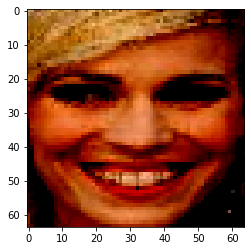

In [136]:
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(dataset1[1])

In [137]:
dataset1.shape

TensorShape([50000, 64, 64, 3])

loading Mnist data

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [9]:
dataset1 = tf.map_fn(fn=tf_resize, elems=train_images)

In [10]:
dataset1.shape

TensorShape([60000, 64, 64, 1])

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64
noise_dim = 100

In [10]:
G = generator(noise_dim)

In [11]:
G.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 256)       1638656   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       8193

In [28]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(dataset1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = G(noise, training=True)
        
        real_output = D(images, training=True)
        fake_output = D(generated_images, training=True)

        #gen_loss = generator_loss(fake_output)
        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        total_loss = gen_loss + disc_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    total_loss_tracker.update_state(total_loss)

In [40]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        print('starting epoch {}'.format(epoch))
        
        for image_batch in dataset:   
            if image_batch.shape[0]==BATCH_SIZE:
                train_step(image_batch)
        print ('Time for epoch {} is {} sec, loss {}'.format(epoch + 1, time.time()-start, total_loss_tracker.result()))
        
'''
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        print('starting epoch')
        train_step(image_batch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
'''

"\ndef train(dataset, epochs):\n    for epoch in range(epochs):\n        start = time.time()\n\n    for image_batch in dataset:\n        print('starting epoch')\n        train_step(image_batch)\n        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))\n"

In [41]:
train(train_dataset, 20)

starting epoch 0


ValueError: in converted code:

    <ipython-input-39-a97da3e6ce10>:12 train_step  *
        gen_loss = generator_loss(real_output, fake_output)
    <ipython-input-33-6e8b2ad9bfcc>:2 generator_loss  *
        features_fake = tf.reduce_mean(intermediate_D(fake_output))
    C:\Users\tghosh\AppData\Local\Continuum\anaconda3\envs\dl2\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:778 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\tghosh\AppData\Local\Continuum\anaconda3\envs\dl2\lib\site-packages\tensorflow_core\python\keras\engine\network.py:717 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    C:\Users\tghosh\AppData\Local\Continuum\anaconda3\envs\dl2\lib\site-packages\tensorflow_core\python\keras\engine\network.py:891 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    C:\Users\tghosh\AppData\Local\Continuum\anaconda3\envs\dl2\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:737 __call__
        self.name)
    C:\Users\tghosh\AppData\Local\Continuum\anaconda3\envs\dl2\lib\site-packages\tensorflow_core\python\keras\engine\input_spec.py:177 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [64, 1]


Feature Matching

In [31]:
intermediate_D = Model(D.inputs, D.get_layer('conv2d_2').output)

In [33]:
def generator_loss(real_output, fake_output):
    features_fake = tf.reduce_mean(intermediate_D(fake_output))
    features_real = tf.reduce_mean(intermediate_D(real_output))
    
    return cross_entropy(tf.ones_like(fake_output), fake_output) \
               + tf.square(tf.norm(features_fake-features_real))

# Minibatch discrimination

In [4]:
D = 5
K = 2
d = 3
n = 10

In [5]:
M1 = tf.random.uniform([D,d])
M2 = tf.random.uniform([D,d])

In [6]:
M1

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.90905535, 0.10405719, 0.09131753],
       [0.02863705, 0.5825683 , 0.846153  ],
       [0.8478004 , 0.39795244, 0.977985  ],
       [0.48442566, 0.14110696, 0.4586779 ],
       [0.9102944 , 0.35196173, 0.42107034]], dtype=float32)>

In [7]:
M2

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.3017695 , 0.39971697, 0.23777246],
       [0.7239461 , 0.1621412 , 0.9364575 ],
       [0.12033594, 0.26026547, 0.09884906],
       [0.51685464, 0.46610165, 0.24875021],
       [0.67990506, 0.58456385, 0.65823436]], dtype=float32)>

In [10]:
tf.concat([tf.expand_dims(M1, axis=1), tf.expand_dims(M2, axis=1)], axis=1)

<tf.Tensor: shape=(5, 2, 3), dtype=float32, numpy=
array([[[0.90905535, 0.10405719, 0.09131753],
        [0.3017695 , 0.39971697, 0.23777246]],

       [[0.02863705, 0.5825683 , 0.846153  ],
        [0.7239461 , 0.1621412 , 0.9364575 ]],

       [[0.8478004 , 0.39795244, 0.977985  ],
        [0.12033594, 0.26026547, 0.09884906]],

       [[0.48442566, 0.14110696, 0.4586779 ],
        [0.51685464, 0.46610165, 0.24875021]],

       [[0.9102944 , 0.35196173, 0.42107034],
        [0.67990506, 0.58456385, 0.65823436]]], dtype=float32)>

In [11]:
T = tf.random.uniform([D,K,d])
T

<tf.Tensor: shape=(5, 2, 3), dtype=float32, numpy=
array([[[0.46842444, 0.95186114, 0.31345356],
        [0.13825059, 0.97335446, 0.23805988]],

       [[0.94486415, 0.35316324, 0.04996717],
        [0.68308115, 0.33421838, 0.523685  ]],

       [[0.52339494, 0.6992692 , 0.32730103],
        [0.9215299 , 0.7267034 , 0.9626744 ]],

       [[0.8449619 , 0.03745961, 0.00374424],
        [0.7552904 , 0.64674604, 0.8571209 ]],

       [[0.06938469, 0.3339815 , 0.35222828],
        [0.09033382, 0.82826924, 0.0475359 ]]], dtype=float32)>

In [15]:
fx = tf.random.uniform([n,D])
fx

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0.53579485, 0.22043848, 0.8512554 , 0.59364235, 0.65108776],
       [0.73988545, 0.39897418, 0.20312929, 0.01949179, 0.2785219 ],
       [0.6069597 , 0.7328167 , 0.95966136, 0.9818381 , 0.60199976],
       [0.08119547, 0.34293687, 0.32639813, 0.581118  , 0.4305358 ],
       [0.09046173, 0.70486414, 0.20708644, 0.1790334 , 0.24359715],
       [0.16241229, 0.89631736, 0.4913243 , 0.34857726, 0.08707452],
       [0.194008  , 0.2368406 , 0.63229895, 0.5901879 , 0.7823255 ],
       [0.54715204, 0.11998951, 0.7310027 , 0.34351993, 0.39887214],
       [0.07517326, 0.9402046 , 0.7718631 , 0.7783884 , 0.77729225],
       [0.21187091, 0.36405015, 0.9708501 , 0.21774459, 0.05188632]],
      dtype=float32)>

In [34]:
multFeatures = tf.einsum('ij,jkl->ikl',fx, T)

In [35]:
multFeatures

<tf.Tensor: shape=(10, 2, 3), dtype=float32, numpy=
array([[[1.1593724 , 0.89375454, 1.1838686 ],
        [1.6287289 , 0.86550575, 0.95010316]],

       [[0.81288606, 0.4292936 , 0.6704326 ],
        [0.7319595 , 0.61242396, 0.33454993]],

       [[1.5114806 , 1.1587211 , 1.8809394 ],
        [2.3181956 , 1.4139124 , 1.0895185 ]],

       [[0.67099416, 0.61236584, 0.8701151 ],
        [1.1907641 , 0.6277503 , 0.5562905 ]],

       [[0.5776517 , 0.29786566, 0.64153343],
        [1.0281054 , 0.6158545 , 0.29951787]],

       [[0.7304951 , 0.36885646, 0.99748605],
        [1.3451461 , 0.8887679 , 0.38519326]],

       [[0.97882664, 0.82929736, 0.96723014],
        [1.5929219 , 0.70404845, 0.8988024 ]],

       [[0.884442  , 0.61734825, 0.85950136],
        [1.1161121 , 0.6410435 , 0.6862852 ]],

       [[1.2765102 , 0.9387132 , 1.4809382 ],
        [2.3712895 , 1.2054871 , 1.0078902 ]],

       [[0.6213804 , 0.27805644, 0.7278147 ],
        [1.1022834 , 0.61443794, 0.5242152 ]]], dtype=fl

In [36]:
multFeaturesExpanded1 = tf.expand_dims(multFeatures,[1])
multFeaturesExpanded1.shape

TensorShape([10, 1, 2, 3])

In [37]:
fn = lambda x: x - multFeatures

In [43]:
row_wise_difference =  tf.abs(tf.map_fn(fn, multFeaturesExpanded1))

In [44]:
row_wise_difference

<tf.Tensor: shape=(10, 10, 2, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.46486390e-01, 4.64460939e-01, 5.13436019e-01],
         [8.96769345e-01, 2.53081799e-01, 6.15553260e-01]],

        [[3.52108121e-01, 2.64966547e-01, 6.97070718e-01],
         [6.89466715e-01, 5.48406661e-01, 1.39415383e-01]],

        [[4.88378286e-01, 2.81388700e-01, 3.13753545e-01],
         [4.37964797e-01, 2.37755477e-01, 3.93812656e-01]],

        [[5.81720769e-01, 5.95888853e-01, 5.42335212e-01],
         [6.00623488e-01, 2.49651253e-01, 6.50585294e-01]],

        [[4.28877354e-01, 5.24898052e-01, 1.86382592e-01],
         [2.83582807e-01, 2.32621431e-02, 5.64909935e-01]],

        [[1.80545807e-01, 6.44571781e-02, 2.16638505e-01],
         [3.58070135e-02, 1.61457300e-01, 5.13007641e-02]],

        [[2.74930477e-01, 2.76406288e-01, 3.24367285e-01],
         [5.12616754e-01, 2.24462271e-01, 2.6

In [39]:
row_wise_difference = tf.abs(
    tf.map_fn(lambda x: x - multFeatures,
              tf.expand_dims(multFeatures,[1])))

In [47]:
multFeaturesDiff = tf.exp(
            -tf.reduce_sum(
                tf.abs(
                    tf.map_fn(fn, multFeaturesExpanded1)
                ),
            axis=[3])
        )
output = tf.reduce_sum(multFeaturesDiff, axis=[1])

In [48]:
output

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[4.250483 , 4.1750574],
       [5.1263275, 4.1288443],
       [2.3254416, 2.623477 ],
       [5.337405 , 5.3628964],
       [4.67772  , 4.857558 ],
       [5.12842  , 4.490942 ],
       [4.896645 , 4.4156637],
       [5.37877  , 5.201411 ],
       [3.5418372, 2.8678563],
       [4.9243836, 5.3776045]], dtype=float32)>

In [70]:
output = tf.reduce_sum(multFeaturesDiff, axis=[1])
output

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.05289634, 0.01884498, 0.02495264, 0.09018894],
       [0.1362008 , 0.05144521, 0.11096726, 0.2175933 ],
       [0.08272877, 0.04497003, 0.02741747, 0.0881411 ],
       [0.8385502 , 0.41891354, 0.17943019, 0.7977139 ],
       [0.32605034, 0.14356598, 0.2867352 , 0.9662033 ]], dtype=float32)>

WGAN

In [71]:
def discriminator_loss_wasserstein(real_output, fake_output):
    return tf.reduce_mean(real_output) -tf.reduce_mean(fake_output)

In [72]:
def generator_loss_wasserstein(real_output, fake_output):
    return -tf.reduce_mean(fake_output)

Weight Clipping for the discriminator ( this must be added to train step)

In [85]:
for p in D.trainable_variables:
    p.assign( tf.clip_by_value(p, -0.01, +0.01)) 

Gradient Penalty

In [65]:
def gradient_penalty(real_output, fake_output):
    epsilon = tf.random.uniform([real_output.shape[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real_output + (1 - epsilon) * fake_output
    with tf.GradientTape() as tape:
        tape.watch(x_hat)
        d_hat = D(x_hat)
    gradients = tape.gradient(d_hat, x_hat)
    gradnorm_sqr_reg = tf.reduce_mean((tf.norm(gradients) - 1.0) ** 2)
    return gradnorm_sqr_reg

In [66]:
re = tf.random.uniform([5, 64,64,3], 1.0, 2.0 )
fk = tf.random.uniform([5, 64,64,3], 1.0, 2.0)
gradient_penalty(re, fk)


<tf.Tensor: shape=(), dtype=float32, numpy=0.7859294>

In [59]:
m

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.0725139, 1.2218661],
       [1.2067604, 1.664377 ]], dtype=float32)>

In [53]:
tf.norm(m)

<tf.Tensor: shape=(), dtype=float32, numpy=2.6210046>

In [54]:
tf.sqrt(tf.reduce_sum(tf.square(m), axis=[0,1]))

<tf.Tensor: shape=(), dtype=float32, numpy=2.6210046>

In [44]:
epsilon = tf.random.uniform([32, 1, 1, 1], 0.0, 1.0)
epsilon    

<tf.Tensor: shape=(32, 1, 1, 1), dtype=float32, numpy=
array([[[[7.5757933e-01]]],


       [[[9.7111738e-01]]],


       [[[7.8766191e-01]]],


       [[[2.7573109e-04]]],


       [[[6.7579710e-01]]],


       [[[9.9856865e-01]]],


       [[[3.7026906e-01]]],


       [[[4.6745968e-01]]],


       [[[6.1199844e-01]]],


       [[[4.6081674e-01]]],


       [[[1.6070724e-01]]],


       [[[4.9116135e-01]]],


       [[[3.8885331e-01]]],


       [[[6.4160383e-01]]],


       [[[9.0654933e-01]]],


       [[[7.4432731e-01]]],


       [[[4.2748213e-02]]],


       [[[7.7904367e-01]]],


       [[[8.7087131e-01]]],


       [[[7.9574490e-01]]],


       [[[6.7831457e-01]]],


       [[[5.6840730e-01]]],


       [[[6.2250793e-01]]],


       [[[7.7842081e-01]]],


       [[[8.5946381e-01]]],


       [[[1.7112136e-02]]],


       [[[7.0106506e-02]]],


       [[[9.9626327e-01]]],


       [[[1.6848350e-01]]],


       [[[2.8739107e-01]]],


       [[[3.3128870e-01]]],


       [[[2.911

Conditional GAN Model

CelebA comes with a list of 40 binary attributes. Theses attributes include gender. We can extract that as the class label and we have a binary class label. 

In [108]:
def discriminator():
    img = layers.Input(shape=[64,64,3])
    label = layers.Input(shape=[2,]) #for two classes
    y = layers.Dense(64*64)(label)
    x = layers.LeakyReLU(0.2)(x)
    y = layers.Reshape((64,64,1))(y)
    
    x = layers.concatenate([img, y])
    
    x = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(x)
    for filter_size in [256, 512,1024]:
        x = layers.Conv2D(filters=filter_size, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return Model(inputs = [img, label], outputs = x)
    

In [109]:
D= discriminator()

In [110]:
D.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 4096)         12288       input_21[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 64, 64, 1)    0           dense_15[0][0]                   
___________________________________________________________________________________________

In [20]:
def generator(noise_dim):
    z = layers.Input(shape=noise_dim)
    x = layers.Dense(units=7*7*256)(z)
    x = layers.Reshape((7,7,256))(x)
    
    label = layers.Input(shape=[2,]) #for two classes
    y = layers.Dense(7*7)(label)
    x = layers.LeakyReLU(0.2)(x)
    y = layers.Reshape((7,7,1))(y)
    
    x = layers.concatenate([x, y])

    for filter_size in [256,128, 64, num_channels]:
        x = layers.Conv2DTranspose(filters=filter_size, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)
    return Model(inputs = [z, label], outputs=x)

In [21]:
G = generator(noise_dim)

In [19]:
G.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 12544)        1266944     input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 7, 7, 256)    0           dense_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = G(noise, training=True)
        fake_labels = np.random.randint(0, 2, BATCH_SIZE)
        
        real_output = D([images,labels], training=True)
        fake_output = D([generated_images,fake_labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

Conditional GAN weith Resnet 50

In [26]:
from tensorflow.keras.applications import ResNet50

In [27]:
resnet = ResNet50(include_top=False,weights="imagenet",)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 19s 0us/step


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
np.random.randint(500, 699, 10)

array([655, 521, 600, 560, 582, 544, 591, 694, 597, 652])